# Re-treinamento dos modelos

- Neste notebook são feitos os treinamentos dos modelos de regressão usando os datasets balanceados (gerados no notebook 06) e validados num setup de k-fold.

- É realizado também o teste de ajuste das respostas em funçao das distribuições dos valores verdadeiros dados os valores preditos (ajustes em função de $p(y_{verdad}|y_{estim})$.


## Conectando ao Google Drive

In [1]:
## Conectando o notebook com o Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Testando se o notebook acessa o Drive corretamente
!ls 'drive/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'My Drive'  'Shared drives'


In [2]:
#  Mover a pasta compartilhada para algum lugar em seu proprio drive, 
#  para conseguir acessar um atalho para o diretorio a partir daqui.

## Configurar essa variavel de ambiente (path_dados) para cada pessoa
## Meu caminho no drive (alexandre)
%env drv=drive/My Drive
%env proj=Aulas/2019_2/ie301-projeto/projeto

!ls "$drv/$proj/dados/"
!echo "-------"
!ls .

env: drv=drive/My Drive
env: proj=Aulas/2019_2/ie301-projeto/projeto
dataset-preprocessado.pkl  old			    train_downsample_100.csv
features.pkl		   sample_submission.csv    x_segments.pkl
new_dataset_kfold.pkl	   test_downsampled
new_features_kfold.pkl	   test_downsampled.tar.gz
-------
drive  sample_data


## Importando bibliotecas

In [3]:
## Basic imports
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

## Utils
import timeit
import time
from tqdm import tqdm
import pickle

## Random seeds
## Meu RA: 137943
from numpy.random import seed
seed(137)
from tensorflow import set_random_seed
set_random_seed(943)

Populating the interactive namespace from numpy and matplotlib


## Preparando dados

### Carregando dados

In [4]:
!cp "$drv/$proj/dados/new_dataset_kfold.pkl" .
with open('new_dataset_kfold.pkl', 'rb') as f:
    dados = pickle.load(f)
    f.close()
dados.keys()

dict_keys(['segments_by_eq', 'ttfs_by_eq', 'segments_by_fold', 'ttfs_by_fold'])

In [0]:
segments_by_fold = dados['segments_by_fold']
ttfs_by_fold = dados['ttfs_by_fold']

### Gerando features

In [0]:
!cp "$drv/$proj/notebooks/utils/features.py" .
import features
import importlib

In [0]:
importlib.reload(features)
feat_gen = features.FeatureGenerator()

In [0]:
feats_by_fold = []
for k in range(3):
    print('\n====\nk={:d}\n===='.format(k+1))
    feats = feat_gen.gen_features(segments_by_fold[k])
    feats_by_fold.append(feats['df_feats'])

cols_mfcc = feats['cols_mfcc']
cols_stat = feats['cols_stat']

  0%|          | 21/6547 [00:00<00:32, 202.94it/s]


====
k=1
====

Gerando features MFCC:


100%|██████████| 6547/6547 [00:33<00:00, 194.05it/s]


Gerando e adicionando features STAT ao DataFrame:
	 - Variância ...
	 - Curtose ...
	 - Quantil ...
	 - Threshold ...


  0%|          | 22/6833 [00:00<00:32, 211.10it/s]


====
k=2
====

Gerando features MFCC:


100%|██████████| 6833/6833 [00:34<00:00, 196.83it/s]


Gerando e adicionando features STAT ao DataFrame:
	 - Variância ...
	 - Curtose ...
	 - Quantil ...
	 - Threshold ...


  0%|          | 20/7079 [00:00<00:36, 193.46it/s]


====
k=3
====

Gerando features MFCC:


100%|██████████| 7079/7079 [00:36<00:00, 196.52it/s]


Gerando e adicionando features STAT ao DataFrame:
	 - Variância ...
	 - Curtose ...
	 - Quantil ...
	 - Threshold ...


In [0]:
for k in range(3):
    feats_by_fold[k]['y'] = ttfs_by_fold[k]

In [0]:
df_feats = feats_by_fold[0]

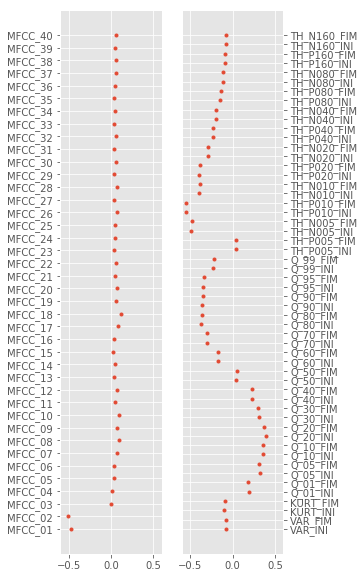

In [0]:
with plt.style.context('ggplot'):
    figsize(4,10)
    ax1 = subplot(121)
    df = df_feats[cols_mfcc+['y']]
    ax = plt.plot(df.corr()['y'].values[:-1], np.arange(len(cols_mfcc)), '.');
    plt.grid(True)
    plt.yticks(np.arange(df[cols_mfcc+['y']].shape[1]-1), cols_mfcc, rotation='horizontal');
    plt.xlim([-.6,.6])

    ax2 = subplot(122)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    df = df_feats[cols_stat+['y']]
    plt.plot(df.corr()['y'].values[:-1], np.arange(len(cols_stat)), '.');
    plt.grid(True)
    plt.yticks(np.arange(df[cols_stat+['y']].shape[1]-1), cols_stat, rotation='horizontal');
    plt.xlim([-.6,.6])
    # savefig('plot_feat_corr.eps', dpi=400, format='eps')
    # savefig('plot_feat_corr.png', dpi=400, format='png')

#### Gravando features


In [0]:
novas_features = {
    'feats_by_fold': feats_by_fold,
    'cols_mfcc': cols_mfcc,
    'cols_stat': cols_stat,
    }
with open('new_features_kfold.pkl', 'wb') as f:
    pickle.dump(novas_features, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()
!cp new_features_kfold.pkl "$drv/$proj/dados/"

### Carregando features

In [0]:
!cp "$drv/$proj/dados/new_features_kfold.pkl" .
with open('new_features_kfold.pkl', 'rb') as f:
    novas_features = pickle.load(f)
    f.close()

feats_by_fold = novas_features['feats_by_fold']
cols_mfcc = novas_features['cols_mfcc']
cols_stat = novas_features['cols_stat']

# Experimento de pós-processamento
- Dadas as predições $\hat{y}$ e os valores verdadeiros $y$, serão calculadas as medianas das distribuições $p(y|\hat{y})$
- Esses cálculos serão feitos em pequenos intervalos de $\hat{y}$
- Em seguida, dois ajustes alternativos serão testados:   
    1. Substituição completa dos valores: $y_{ajustado}=y$, ou;
    2. Ajuste ponderado dos valores: $y_{ajustado}=(1-\epsilon)\hat{y}+\epsilon y$, onde $\epsilon\in[0,1]$.
- Este processo será feito para cada iteração do k-fold e o desempenho médio será utilizado para calcular o desempenho estimado.
- Será realizado este experimento para os modelos:
    - Regressão Linear + features extraídas
    - Rede Neural Convolucional + entrada pura


### Funções auxiliares

In [0]:
def kfold_indexes(kfolds):
    indexes = np.arange(kfolds)
    return list(((indexes[indexes!=n]), (n)) for n in indexes)

# ## K-Fold
# for train, valid in kfold_indexes(3):
#     ## fixo para k=3 (problema com lista de dataframe..)
#     x_train = np.concatenate((feats_by_fold[train[0]][cols].values, 
#      feats_by_fold[train[1]][cols].values), axis=0)
#     y_train = np.concatenate((ttfs_by_fold[train[0]][cols].values, 
#      ttfs_by_fold[train[1]][cols].values), axis=0)
#     x_valid = feats_by_fold[valid]
#     y_valid = ttfs_by_fold[valid]


In [0]:
def mae(pred, true):
    """ mae(pred, true)
    
        Retorna o erro absoluto medio.
    """
    return(np.mean(np.abs(pred-true)))

def medianas_dist_condicional(pred, true, y_range):
    """ medianas_dist_condicional(pred, true)
        Retorna a mediana das distribuições verdadeiras dados os
        valores preditos. Mediana[p(y_true|y_pred)].
    """
    return(np.array([np.median(true[(pred >= val) & (pred < val+0.1)]) for val in y_range]))

In [0]:
def ajusta_distribuicao(y_orig, y_ref, y_range, epsilon=1):
    """ ajusta_distribuicao(y_orig, y_ref, y_range, epsilon=1):

        Aplica o ajuste das medianas das distribuições encontradas
        no conjunto de treino, sobre um dado vetor de predições
        qualquer (treino, validação ou teste).
    """
    y_adj = np.copy(y_orig)
    for i in range(len(y_range)):
        val = y_range[i]
        idx = (y_orig >= val) & (y_orig < val+0.1)
        y_adj[idx] = y_adj[idx]*(1-epsilon) + y_ref[i]*epsilon
    return(y_adj)

In [0]:
def resultado_ajuste(modelo, x_train, y_train, x_valid, y_valid, nome_modelo, y_range=np.arange(0, 10.5,.1), do_plot=False, do_save=False):
    ## resultados
    y_pred_train = modelo.predict(x_train).ravel()
    y_pred_valid = modelo.predict(x_valid).ravel()
    y_pred_train[y_pred_train < 0] = 0
    y_pred_valid[y_pred_valid < 0] = 0

    ## pontuacoes
    pred_score_train = np.mean(np.abs((y_pred_train-y_train)))
    pred_score_valid = np.mean(np.abs((y_pred_valid-y_valid)))

    ## mediana das distribuições verdadeiras dado o valor predito p(y_true|y_pred)
    y_med_pred_train = medianas_dist_condicional(y_pred_train, y_train, y_range)
    y_med_pred_valid = medianas_dist_condicional(y_pred_valid, y_valid, y_range)

    ## Ajuste do resultado em função da mediana
    y_pred_train_adj_half = ajusta_distribuicao(y_pred_train, y_med_pred_train, y_range, epsilon=0.5)
    y_pred_valid_adj_half = ajusta_distribuicao(y_pred_valid, y_med_pred_train, y_range, epsilon=0.5)
    y_med_pred_train_adj_half = medianas_dist_condicional(y_pred_train_adj_half, y_train, y_range)
    y_med_pred_valid_adj_half = medianas_dist_condicional(y_pred_valid_adj_half, y_valid, y_range)

    y_pred_train_adj_full = ajusta_distribuicao(y_pred_train, y_med_pred_train, y_range, epsilon=1.0)
    y_pred_valid_adj_full = ajusta_distribuicao(y_pred_valid, y_med_pred_train, y_range, epsilon=1.0)
    y_med_pred_train_adj_full = medianas_dist_condicional(y_pred_train_adj_full, y_train, y_range)
    y_med_pred_valid_adj_full = medianas_dist_condicional(y_pred_valid_adj_full, y_valid, y_range)

    pred_score_train_adj_half = mae(y_pred_train_adj_half, y_train)
    pred_score_valid_adj_half = mae(y_pred_valid_adj_half, y_valid)
    pred_score_train_adj_full = mae(y_pred_train_adj_full, y_train)
    pred_score_valid_adj_full = mae(y_pred_valid_adj_full, y_valid)

    if(do_plot):
        alpha=0.20
        with plt.style.context('ggplot'):
            figsize(8,10)
            fig, axs = plt.subplots(3, 2, constrained_layout=True)
            fig.suptitle('Resultados: ' + nome_modelo, fontsize=24)
            
            # subplot(321)
            axs[0,0].plot(y_pred_train, y_train, 'g.', alpha=alpha);
            axs[0,0].plot([0, 14], [0, 14], 'r')
            axs[0,0].plot(y_range, y_med_pred_train, 'bx')
            axs[0,0].set_title('MAE (treino): {:.3f}'.format(pred_score_train))
            axs[0,0].set_ylabel('Valor verdadeiro')
            axs[0,0].set_xlabel('Predição')
            
            # subplot(322)
            axs[0,1].plot(y_pred_valid, y_valid, 'g.', alpha=alpha);
            axs[0,1].plot([0, 14], [0, 14], 'r')
            axs[0,1].plot(y_range, y_med_pred_valid, 'bx')
            axs[0,1].set_title('MAE (validação): {:.3f}'.format(pred_score_valid))
            axs[0,1].set_ylabel('Valor verdadeiro')
            axs[0,1].set_xlabel('Predição')

            # subplot(323)
            axs[1,0].plot(y_pred_train_adj_half, y_train, 'g.', alpha=alpha);
            axs[1,0].plot([0, 14], [0, 14], 'r')
            axs[1,0].plot(y_range, y_med_pred_train_adj_half, 'bx')
            axs[1,0].set_title('MAE (treino) (epsilon=0.5): {:.3f}'.format(pred_score_train_adj_half))
            axs[1,0].set_ylabel('Valor verdadeiro')
            axs[1,0].set_xlabel('Predição ajustada')
            
            # subplot(324)
            axs[1,1].plot(y_pred_valid_adj_half, y_valid, 'g.', alpha=alpha);
            axs[1,1].plot([0, 14], [0, 14], 'r')
            axs[1,1].plot(y_range, y_med_pred_valid_adj_half, 'bx')
            axs[1,1].set_title('MAE (validação) (epsilon=0.5): {:.3f}'.format(pred_score_valid_adj_half))
            axs[1,1].set_ylabel('Valor verdadeiro')
            axs[1,1].set_xlabel('Predição ajustada')

            # subplot(325)
            axs[2,0].plot(y_pred_train_adj_full, y_train, 'g.', alpha=alpha);
            axs[2,0].set_ylabel('Valor verdadeiro')
            axs[2,0].set_xlabel('Predição ajustada')
            axs[2,0].set_title('MAE (treino) (epsilon=1.0): {:.3f}'.format(pred_score_train_adj_full))
            axs[2,0].plot([0, 14], [0, 14], 'r')
            axs[2,0].plot(y_range, y_med_pred_train_adj_full, 'bx')

            # subplot(326)
            axs[2,1].set_title('MAE (validação) (epsilon=1.0): {:.3f}'.format(pred_score_valid_adj_full))
            axs[2,1].plot(y_pred_valid_adj_full, y_valid, 'g.', alpha=alpha);
            axs[2,1].plot([0, 14], [0, 14], 'r')
            axs[2,1].plot(y_range, y_med_pred_valid_adj_full, 'bx')
            axs[2,1].set_ylabel('Valor verdadeiro')
            axs[2,1].set_xlabel('Predição ajustada')

            if(do_save):
                savefig('resultados-ajuste-'+nome_modelo.lower().replace(' ', '-')+'.eps', format='eps', dpi=400)
                savefig('resultados-ajuste-'+nome_modelo.lower().replace(' ', '-')+'.png', format='png', dpi=400)
    
    return({
        'y_med_pred_train' : y_med_pred_train,
        'pred_score_train' : pred_score_train, 
        'pred_score_valid' : pred_score_valid, 
        'pred_score_train_adj_half' : pred_score_train_adj_half, 
        'pred_score_valid_adj_half' : pred_score_valid_adj_half, 
        'pred_score_train_adj_full' : pred_score_train_adj_full, 
        'pred_score_valid_adj_full' : pred_score_valid_adj_full, 
    })

## Regressão Linear

In [0]:
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


lr_score_train:  2.1424574806697883
lr_score_valid:  2.1978679967167785
lr_score_train_adj_half:  2.0974868148333345
lr_score_valid_adj_half:  2.1838262705751386
lr_score_train_adj_full:  2.080202332530686
lr_score_valid_adj_full:  2.197253357866972


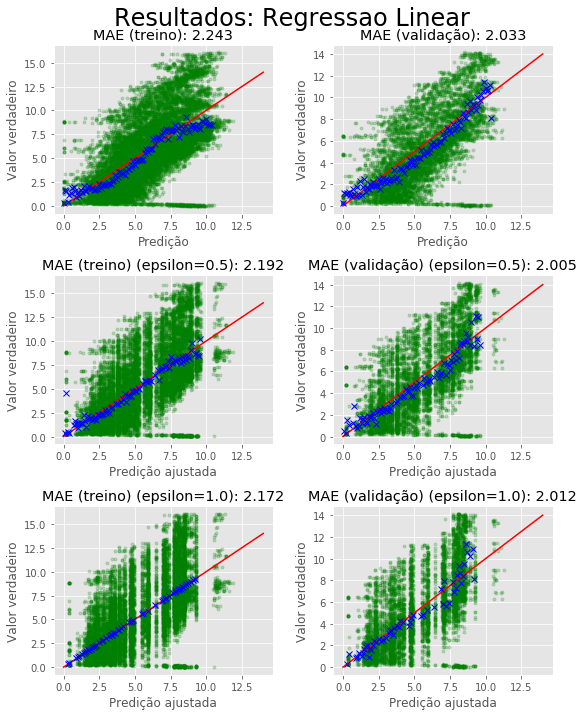

In [12]:
lr_score_train = 0
lr_score_valid = 0
lr_score_train_adj_half = 0
lr_score_valid_adj_half = 0
lr_score_train_adj_full = 0
lr_score_valid_adj_full = 0

cols = cols_mfcc+cols_stat
gera_figura = True
lista_modelos_lr = []
lista_med_lr = []
for train, valid in kfold_indexes(3):
    ## particionamento entre treino e validacao
    x_train = np.concatenate(
        (feats_by_fold[train[0]][cols].values, 
        feats_by_fold[train[1]][cols].values), 
        axis=0)
    y_train = np.concatenate(
        (ttfs_by_fold[train[0]], 
        ttfs_by_fold[train[1]]), 
        axis=0)
    x_valid = feats_by_fold[valid][cols].values
    y_valid = ttfs_by_fold[valid]
    ## treinamento do modelo
    model_lr = LinearRegression()
    model_lr.fit(x_train, y_train)
    lista_modelos_lr.append(model_lr)
    ## resultados
    result = resultado_ajuste(model_lr, x_train, y_train, x_valid, y_valid, 
                                'Regressao Linear',
                              do_plot=gera_figura,
                              do_save=gera_figura)
    gera_figura = False
    
    lista_med_lr.append(result['y_med_pred_train'])
    lr_score_train = lr_score_train + result['pred_score_train']
    lr_score_valid = lr_score_valid + result['pred_score_valid']
    lr_score_train_adj_half = lr_score_train_adj_half + result['pred_score_train_adj_half']
    lr_score_valid_adj_half = lr_score_valid_adj_half + result['pred_score_valid_adj_half']
    lr_score_train_adj_full = lr_score_train_adj_full + result['pred_score_train_adj_full']
    lr_score_valid_adj_full = lr_score_valid_adj_full + result['pred_score_valid_adj_full']

print('lr_score_train: ', lr_score_train/3)
print('lr_score_valid: ', lr_score_valid/3)
print('lr_score_train_adj_half: ', lr_score_train_adj_half/3)
print('lr_score_valid_adj_half: ', lr_score_valid_adj_half/3)
print('lr_score_train_adj_full: ', lr_score_train_adj_full/3)
print('lr_score_valid_adj_full: ', lr_score_valid_adj_full/3)

In [0]:
with open('lista_modelos_lr.pkl', 'wb') as f:
    pickle.dump(lista_modelos_lr, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

with open('lista_med_lr.pkl', 'wb') as f:
    pickle.dump(lista_med_lr, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

!cp lista_modelos_lr.pkl "$drv/$proj/modelos/"
!cp lista_med_lr.pkl "$drv/$proj/modelos/"

## Rede Neural Convolucional

In [13]:
### Keras (usando o backend TensorFlow)
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
# from keras.models import Model

# Layers
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Input

# Optimization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import Adam

# Regularization
from keras.regularizers import l2


Using TensorFlow backend.


In [0]:
def modelo_cnn():
    cnn = Sequential()

    cnn.add(Conv1D(filters=1, kernel_size=10, input_shape=(1500,1), 
                activation='relu',
                kernel_regularizer = l2(l = 0.01)
                ))

    cnn.add(MaxPooling1D(pool_size=5))

    cnn.add(Conv1D(filters=1, kernel_size=10, 
                activation='relu',
                kernel_regularizer = l2(l = 0.01)
                ))

    cnn.add(MaxPooling1D(pool_size=5))

    cnn.add(Flatten())
    cnn.add(Dropout(.10))

    cnn.add(Dense(1, activation='relu'))

    opt = Adam(lr=0.001)
    cnn.compile(optimizer=opt, loss='mean_absolute_error')
    # cnn.summary()
    return(cnn)

FOLD # 1





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 13912 samples, validate on 6547 samples
Epoch 1/150
13912/13912 [==============================] - 8s 576us/step - loss: 6.1121 - val_loss: 5.3624
Epoch 2/150
13912/13912 [==============================] - 1s 52us/step - loss: 5.5530 - val_loss: 5.1700
Epoch 3/150
13912/13912 [==============================] - 1s 51us/step - loss: 5.3400 - val_loss: 4.9143
Epoch 4/150
13912/13912 [==============================] - 1s 52us/step - loss: 4.9400 - val_loss: 4.3759
Epoch 5/150
13912/13912 [==============================] - 1s 52us/step - loss: 4.4182 - val_loss: 3.9279
Epoch 6/150
13912/13912 [==============================] - 1s 49us/step - loss: 4.0085 - val_loss: 3.5986
Epoch 7/150
13912/13912 [==============================] - 1s 50us/step - loss: 3.6955 - val_loss: 3.3236
Epoch 8/150
13912/13912 [==============================] - 1s 50us/step - los

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


FOLD # 2
Train on 13626 samples, validate on 6833 samples
Epoch 1/150
13626/13626 [==============================] - 1s 78us/step - loss: 6.2729 - val_loss: 6.1437
Epoch 2/150
13626/13626 [==============================] - 1s 49us/step - loss: 5.9338 - val_loss: 5.9977
Epoch 3/150
13626/13626 [==============================] - 1s 49us/step - loss: 5.8212 - val_loss: 5.9130
Epoch 4/150
13626/13626 [==============================] - 1s 51us/step - loss: 5.6914 - val_loss: 5.8492
Epoch 5/150
13626/13626 [==============================] - 1s 51us/step - loss: 5.6372 - val_loss: 5.7751
Epoch 6/150
13626/13626 [==============================] - 1s 53us/step - loss: 5.5467 - val_loss: 5.6681
Epoch 7/150
13626/13626 [==============================] - 1s 53us/step - loss: 5.4412 - val_loss: 5.4753
Epoch 8/150
13626/13626 [==============================] - 1s 51us/step - loss: 5.1963 - val_loss: 5.0307
Epoch 9/150
13626/13626 [==============================] - 1s 50us/step - loss: 4.7144 - val_l

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


FOLD # 3
Train on 13380 samples, validate on 7079 samples
Epoch 1/150
13380/13380 [==============================] - 1s 85us/step - loss: 5.5676 - val_loss: 5.5539
Epoch 2/150
13380/13380 [==============================] - 1s 50us/step - loss: 5.0988 - val_loss: 4.8615
Epoch 3/150
13380/13380 [==============================] - 1s 52us/step - loss: 4.3525 - val_loss: 4.1666
Epoch 4/150
13380/13380 [==============================] - 1s 54us/step - loss: 3.8132 - val_loss: 3.7797
Epoch 5/150
13380/13380 [==============================] - 1s 51us/step - loss: 3.5168 - val_loss: 3.5107
Epoch 6/150
13380/13380 [==============================] - 1s 51us/step - loss: 3.2743 - val_loss: 3.2694
Epoch 7/150
13380/13380 [==============================] - 1s 52us/step - loss: 3.0785 - val_loss: 3.0608
Epoch 8/150
13380/13380 [==============================] - 1s 51us/step - loss: 2.8806 - val_loss: 2.8742
Epoch 9/150
13380/13380 [==============================] - 1s 51us/step - loss: 2.7110 - val_l

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


cnn_score_train:  2.187518625450146
cnn_score_valid:  2.200679317251701
cnn_score_train_adj_half:  2.1356266575645053
cnn_score_valid_adj_half:  2.201075558096329
cnn_score_train_adj_full:  2.116062588875114
cnn_score_valid_adj_full:  2.2380071610006294


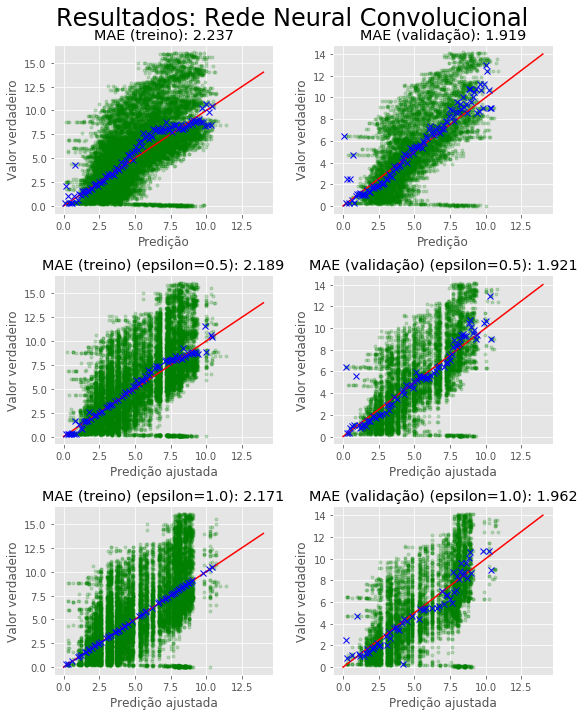

In [15]:
cnn_score_train = 0
cnn_score_valid = 0
cnn_score_train_adj_half = 0
cnn_score_valid_adj_half = 0
cnn_score_train_adj_full = 0
cnn_score_valid_adj_full = 0

cols = cols_mfcc+cols_stat
i = 0
gera_figura = True

lista_modelos_cnn = []
lista_med_cnn = []
for train, valid in kfold_indexes(3):
    i = i+1
    print('FOLD #', i)
    ## particionamento entre treino e validacao
    x_train = np.concatenate(
        (segments_by_fold[train[0]], 
        segments_by_fold[train[1]]), 
        axis=0)
    y_train = np.concatenate(
        (ttfs_by_fold[train[0]], 
        ttfs_by_fold[train[1]]), 
        axis=0)
    x_valid = segments_by_fold[valid]
    y_valid = ttfs_by_fold[valid]
    
    ## formatacao das entradas
    x_train = x_train.reshape([-1, 1500, 1])
    x_valid = x_valid.reshape([-1, 1500, 1])
    ## treinamento do modelo
    cnn = modelo_cnn()
    early_stop = EarlyStopping(monitor='val_loss', 
                            patience=10,
                            restore_best_weights=True
                            )
    history = cnn.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), 
                    batch_size=256,
                    epochs=150,
                    callbacks = [early_stop]
                    )
    lista_modelos_cnn.append(cnn)
    ## resultados
    result = resultado_ajuste(cnn, x_train, y_train, x_valid, y_valid, 
                              'Rede Neural Convolucional',
                              do_plot=gera_figura,
                              do_save=gera_figura)
    gera_figura = False
    
    lista_med_cnn.append(result['y_med_pred_train'])
    cnn_score_train = cnn_score_train + result['pred_score_train']
    cnn_score_valid = cnn_score_valid + result['pred_score_valid']
    cnn_score_train_adj_half = cnn_score_train_adj_half + result['pred_score_train_adj_half']
    cnn_score_valid_adj_half = cnn_score_valid_adj_half + result['pred_score_valid_adj_half']
    cnn_score_train_adj_full = cnn_score_train_adj_full + result['pred_score_train_adj_full']
    cnn_score_valid_adj_full = cnn_score_valid_adj_full + result['pred_score_valid_adj_full']

print('cnn_score_train: ', cnn_score_train/3)
print('cnn_score_valid: ', cnn_score_valid/3)
print('cnn_score_train_adj_half: ', cnn_score_train_adj_half/3)
print('cnn_score_valid_adj_half: ', cnn_score_valid_adj_half/3)
print('cnn_score_train_adj_full: ', cnn_score_train_adj_full/3)
print('cnn_score_valid_adj_full: ', cnn_score_valid_adj_full/3)

In [0]:
with open('lista_modelos_cnn.pkl', 'wb') as f:
    pickle.dump(lista_modelos_cnn, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

with open('lista_med_cnn.pkl', 'wb') as f:
    pickle.dump(lista_med_cnn, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

!cp lista_modelos_cnn.pkl "$drv/$proj/modelos/"
!cp lista_med_cnn.pkl "$drv/$proj/modelos/"

In [0]:
!cp resultados-ajuste-regressao-linear* "$drv/$proj/imagens/"
!cp resultados-ajuste-rede-neural-convolucional* "$drv/$proj/imagens/"

# Resultados

Desempenho de erro absoluto médio na validação 3-fold:

|Modelo|Treino|Validação|
|-|-|-|
|LR|2.14245|2.19786|
|LR ($\epsilon$=0.5)|2.09748|2.18382|
|LR ($\epsilon$=1.0)|2.08020|2.19725|
|CNN|2.18751|2.20067|
|CNN ($\epsilon$=0.5)|2.13562|2.20107|
|CNN ($\epsilon$=1.0)|2.11606|2.23800|

<!-- 
- Regressão Linear
    - Treino
            lr_score_train:  2.1424574806697883
            lr_score_train_adj_half:  2.0974868148333345
            lr_score_train_adj_full:  2.080202332530686
    - Validação
            lr_score_valid:  2.1978679967167785
            lr_score_valid_adj_half:  2.1838262705751386
            lr_score_valid_adj_full:  2.197253357866972

- Rede Neural Convolucional
    - Treino
            cnn_score_train:  2.187518625450146
            cnn_score_train_adj_half:  2.1356266575645053
            cnn_score_train_adj_full:  2.116062588875114
            
    - Validação
            cnn_score_valid:  2.200679317251701
            cnn_score_valid_adj_half:  2.201075558096329
            cnn_score_valid_adj_full:  2.2380071610006294
            
-->

# Extra (comparação com modelo anterior)

In [0]:
## Carregando o modelo
!cp "$drv/$proj/modelos/cnn-regr.pkl" .

with open('cnn-regr.pkl', 'rb') as f:
    dados = pickle.load(f)
    f.close()

cnn_regr = dados['cnn_regr']
del dados

In [0]:
!cp "$drv/$proj/dados/dataset-preprocessado.pkl" .
with open('dataset-preprocessado.pkl', 'rb') as f:
    dados = pickle.load(f)
    f.close()

x_train = dados['x_train']
y_train = dados['y_train']
y_train_cate = dados['y_train_cate']
x_valid = dados['x_valid']
y_valid = dados['y_valid']
y_valid_cate = dados['y_valid_cate']

del dados

In [0]:
x_train = x_train.reshape([-1, 1500, 1])
x_valid = x_valid.reshape([-1, 1500, 1])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


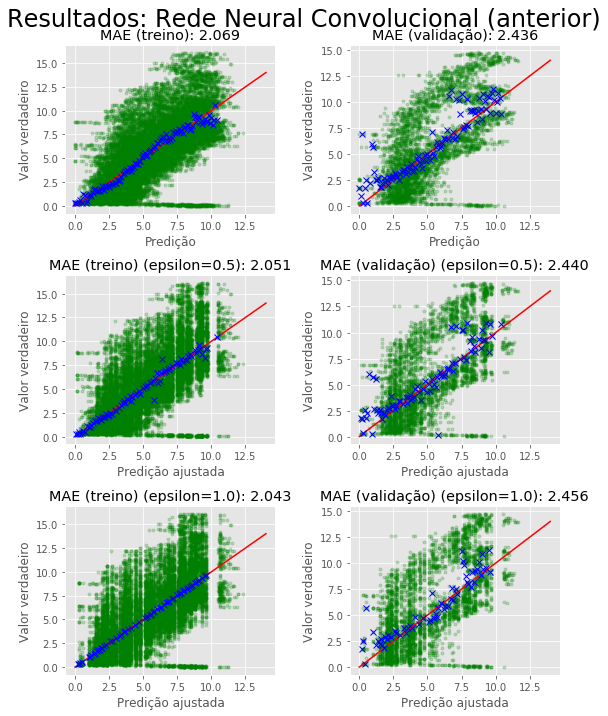

In [0]:
results = resultado_ajuste(cnn_regr, 
                           x_train, y_train, 
                           x_valid, y_valid, 
                           'Rede Neural Convolucional (anterior)', 
                           y_range=np.arange(0, 10.5,.1), 
                           do_plot=True, do_save=True)